In [1]:
# BSNIP

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/BSNIP/AngleBasisLong20.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
sex = []
race = []
sz = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)', subtask)
    sub = m.group(1)
    a = demo['Age_cal'][sub]
    s = demo['sex'][sub] == 's1.0'
    r = demo['Race'][sub] == 'AA'
    z = demo['DXGROUP_2'][sub] in ['SZP', 'SADP', 'BP']
#     if demo['DXGROUP_2'][sub] not in ['SZP', 'NC']:
#         continue
    age.append(a)
    sz.append(z)
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
sz = np.array(sz).astype('int')
fc = np.stack(fc)

print([a.shape for a in [thetas, jitter, sex, race, sz, age, fc]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(1-sz))
print(np.mean(age))

[(1244, 20, 264), (1244, 20, 264), (1244,), (1244,), (1244,), (1244,), (1244, 34716)]
0.5763665594855305
0.6889067524115756
0.727491961414791
38.209807073954984


In [2]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


130
29


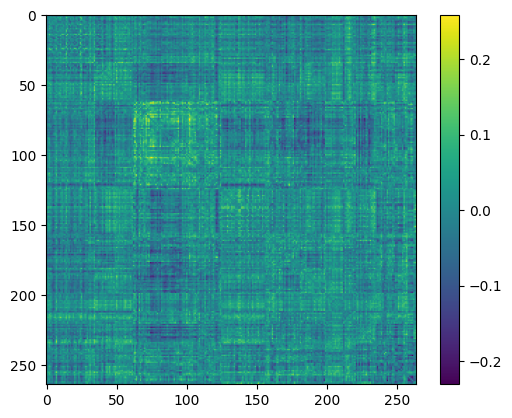

In [85]:
import matplotlib.pyplot as plt

sel = (age < 30)*(sex == 0)*(race == 0)*(sz == 0)
print(np.sum(sel))
avg1 = np.mean(fc[sel], axis=0)

sel = (age < 30)*(sex == 1)*(race == 1)*(sz == 1)
print(np.sum(sel))
avg2 = np.mean(fc[sel], axis=0)

plt.imshow(remap(vec2mat(avg1-avg2)))
plt.colorbar()
plt.show()

In [6]:
# Estimate age, sex, race, sz status

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

mage = 10*[None]

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, age, train_size=800)
    mage[i] = Ridge(alpha=1, max_iter=1000).fit(xtr, ytr)
    print(f'Done {i}')

msex = 10*[None]

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, sex, stratify=sex, train_size=200)
    msex[i] = LogisticRegression(C=1, max_iter=500).fit(xtr, ytr)
    print(f'Done {i}')

mrace = 10*[None]

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, race, stratify=race, train_size=200)
    mrace[i] = LogisticRegression(C=1, max_iter=500).fit(xtr, ytr)
    print(f'Done {i}')
    
msz = 10*[None]

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, sz, stratify=sz, train_size=200)
    msz[i] = LogisticRegression(C=1, max_iter=500).fit(xtr, ytr)
    print(f'Done {i}')

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9


In [7]:
wage = mage[1].coef_.squeeze()
bage = mage[1].intercept_

ahat = fc@wage+bage
print(ahat[0:10])
print(age[0:10])

[23.01437032 52.97552343 51.99314323 50.99423628 46.98086394 33.64746587
 55.87082504 34.11253742 21.03817544 41.92024205]
[23 53 52 51 47 33 41 23 21 35]


In [8]:
wsex = msex[0].coef_.squeeze()
bsex = msex[0].intercept_

shat = fc@wsex+bsex
print(shat[0:10])
print(sex[0:10])

[-0.26545921  5.3633995   2.12081224 -5.40734758 -1.65786112 -3.37627255
  0.87092501  0.60218321  5.2635791   2.77102494]
[1 1 1 0 0 1 0 0 1 0]


In [9]:
wrace = mrace[0].coef_.squeeze()
brace = mrace[0].intercept_

rhat = fc@wrace+brace
print(rhat[0:10])
print(race[0:10])

[-0.63644809 -1.09599496 -6.58014215  2.28548798  4.06465922 -1.90871384
 -3.95899447 -4.53453933 -0.96242083  4.7885441 ]
[1 1 0 1 0 1 0 0 0 1]


In [10]:
wsz = msz[0].coef_.squeeze()
bsz = msz[0].intercept_

zhat = fc@wsz+bsz
print(zhat[0:10])
print(sz[0:10])

[-1.95505413 -0.83100497 -2.18564427 -0.11578307 -3.02797212 -1.86773036
 -5.31563919 -3.89566215  5.04091936 -1.67175536]
[1 1 0 1 0 1 0 0 1 1]


In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import randint

def rmse(yt, yhat):
    return torch.mean((yt-yhat)**2)**0.5

class Gen(nn.Module):
    def __init__(self, mage, msex, mrace, msz):
        super(Gen, self).__init__()
        self.wage = []
        self.bage = []
        self.wsex = []
        self.bsex = []
        self.wrace = []
        self.brace = []
        self.wsz = []
        self.bsz = []
        for mod in mage:
            self.wage.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bage.append(torch.Tensor([mod.intercept_]).float().cuda())
        for mod in msex:
            self.wsex.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bsex.append(torch.from_numpy(mod.intercept_).float().cuda())
        for mod in mrace:
            self.wrace.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.brace.append(torch.from_numpy(mod.intercept_).float().cuda())
        for mod in msz:
            self.wsz.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bsz.append(torch.from_numpy(mod.intercept_).float().cuda())
        self.A = nn.Parameter(1/(264*10)**0.5*torch.randn(264,10).float().cuda())
#         self.thetas = nn.Parameter(torch.randn(5,264).float().cuda())
        
    def fcimg(self):
#         t0 = self.thetas.unsqueeze(2)
#         t1 = self.thetas.unsqueeze(1)
#         m = torch.einsum('ab,cb->bac',self.A,self.A)
#         return torch.mean(m*torch.cos(t0-t1), axis=0)
        return self.A@self.A.T
    
    def fc(self):
        a,b = torch.triu_indices(264,264,offset=1)
        return self.fcimg()[a,b]
    
    def predict(self, age, sex, race, sz):
        aerr = []
        serr = []
        rerr = []
        zerr = []
        efc = self.fc()
        for w,b in zip(self.wage, self.bage):
            aerr.append(rmse(age, w@efc+b))
        for w,b in zip(self.wsex, self.bsex):
            serr.append(torch.abs(sex-w@efc+b))
        for w,b in zip(self.wrace, self.brace):
            rerr.append(torch.abs(race-w@efc+b))
        for w,b in zip(self.wsz, self.bsz):
            zerr.append(torch.abs(sz-w@efc+b))
        return sum(aerr)/len(aerr), sum(serr)/len(serr), sum(rerr)/len(rerr), sum(zerr)/len(zerr)
    
nepochs = 100
pperiod = 100

subj1 = []
subj2 = []

for n in range(10):
    gen = Gen(mage, msex, mrace, msz)
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))
        fcloss2 = 10*rmse(fc_mu, gen.fc())

        aloss, sloss, rloss, zloss = gen.predict(30, -10, -10, -10)
        (fcloss+fcloss2+aloss+sloss+rloss+zloss).backward()

        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(fcloss2)} {float(aloss)} {float(sloss)} {float(rloss)} {float(zloss)}')
            
    subj1.append(gen.fcimg().detach().cpu().numpy())
    
for n in range(10):
    gen = Gen(mage, msex, mrace, msz)
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))
        fcloss2 = 10*rmse(fc_mu, gen.fc())

        aloss, sloss, rloss, zloss = gen.predict(30, 10, 10, 10)
        (fcloss2+aloss+sloss+rloss+zloss).backward()

        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(fcloss2)} {float(aloss)} {float(sloss)} {float(rloss)} {float(zloss)}')
            
    subj2.append(gen.fcimg().detach().cpu().numpy())

0 22.998788833618164 24.175384521484375 13.114082336425781 12.285202026367188 12.251524925231934
99 18.226945877075195 1.166748285293579 0.4354480803012848 0.6728171110153198 0.7333534955978394
0 22.998247146606445 24.163379669189453 13.112489700317383 12.284735679626465 12.251588821411133
99 17.817604064941406 1.2346327304840088 0.4229719340801239 0.6487926244735718 0.5904789566993713
0 22.99892234802246 24.1405086517334 13.11253833770752 12.285017967224121 12.253508567810059
99 17.61321258544922 1.1550028324127197 0.33309534192085266 0.6181467771530151 0.7604895234107971
0 22.998506546020508 24.13606834411621 13.114242553710938 12.285374641418457 12.254364967346191
99 17.751113891601562 0.469443142414093 0.4075588285923004 0.570529043674469 0.6043073534965515
0 22.99905014038086 24.158720016479492 13.112283706665039 12.286147117614746 12.253583908081055
99 18.10051727294922 0.9868127703666687 0.5462643504142761 0.8251308798789978 0.6777287125587463
0 22.9984130859375 24.1492156982421

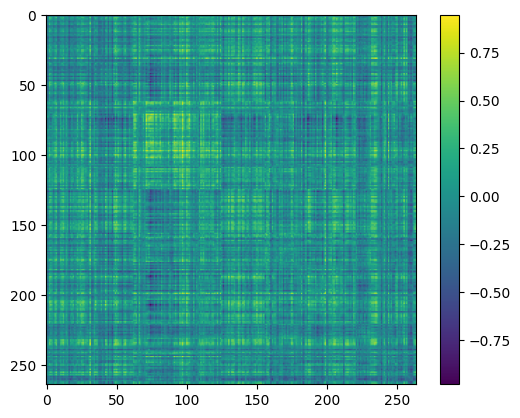

In [76]:
import matplotlib.pyplot as plt

plt.imshow(remap(np.mean(np.stack(subj1), axis=0)-np.mean(np.stack(subj2), axis=0)))
# plt.imshow(remap(subj1[0]))
plt.colorbar()
plt.show()

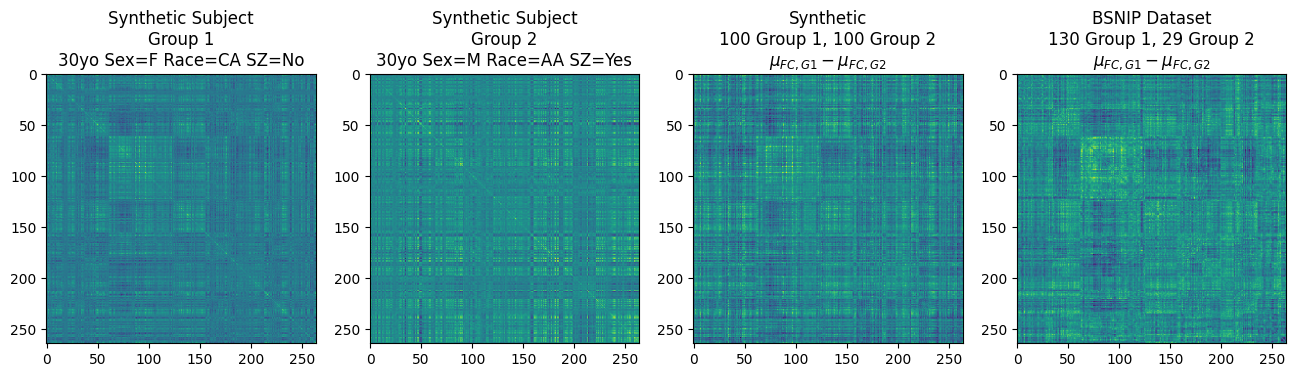

In [45]:
fig, ax = plt.subplots(1,4,figsize=(16,5))

ax[0].imshow(remap(subj1[0]))
ax[0].set_title('Synthetic Subject\nGroup 1\n30yo Sex=F Race=CA SZ=No')

ax[1].imshow(remap(subj2[0]))
ax[1].set_title('Synthetic Subject\nGroup 2\n30yo Sex=M Race=AA SZ=Yes')

ax[2].imshow(remap(np.mean(np.stack(subj1), axis=0)-np.mean(np.stack(subj2), axis=0)))
ax[2].set_title('Synthetic\n100 Group 1, 100 Group 2\n$\mu_{FC,G1}-\mu_{FC,G2}$')

ax[3].imshow(remap(vec2mat(avg1-avg2)))
ax[3].set_title('BSNIP Dataset\n130 Group 1, 29 Group 2\n$\mu_{FC,G1}-\mu_{FC,G2}$')

# fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/SyntheticMean.pdf')
fig.show()

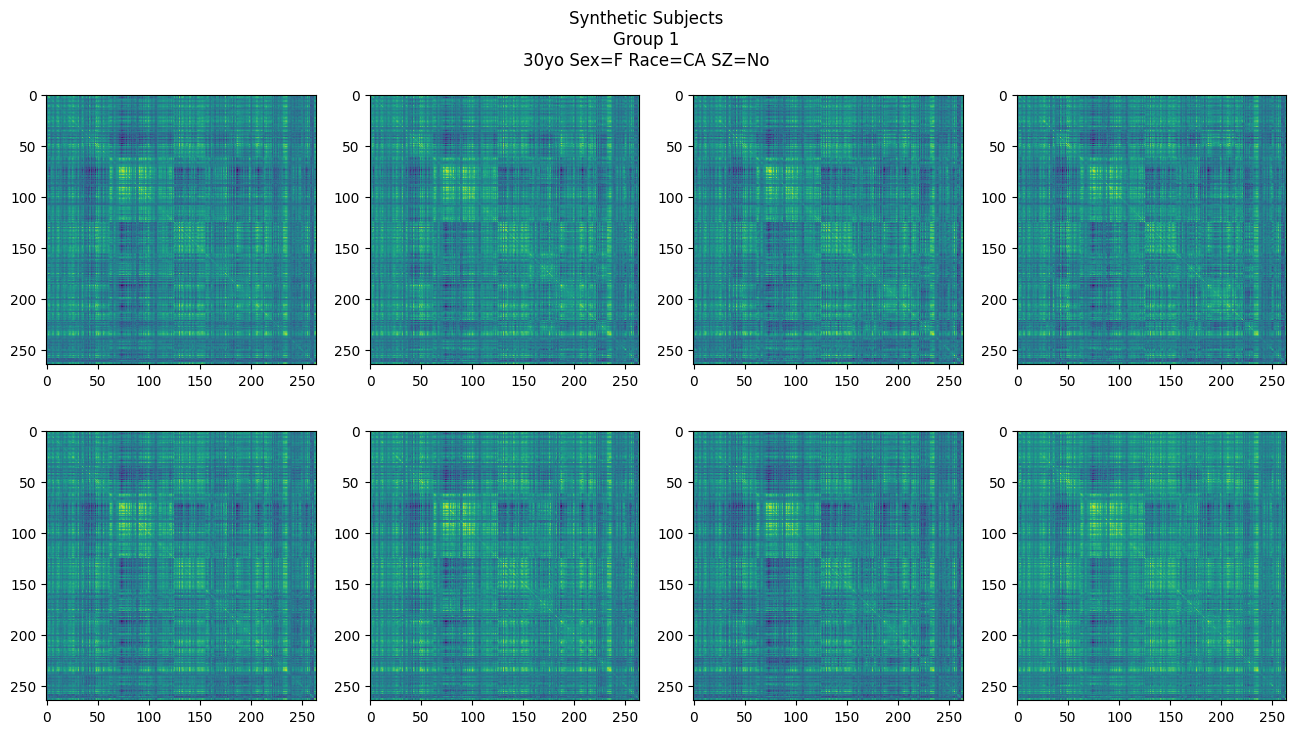

In [77]:
fig, ax = plt.subplots(2,4,figsize=(16,8))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(subj1[i*4+j]))
        
fig.suptitle('Synthetic Subjects\nGroup 1\n30yo Sex=F Race=CA SZ=No')
# fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/SyntheticGroup1.pdf')
fig.show()

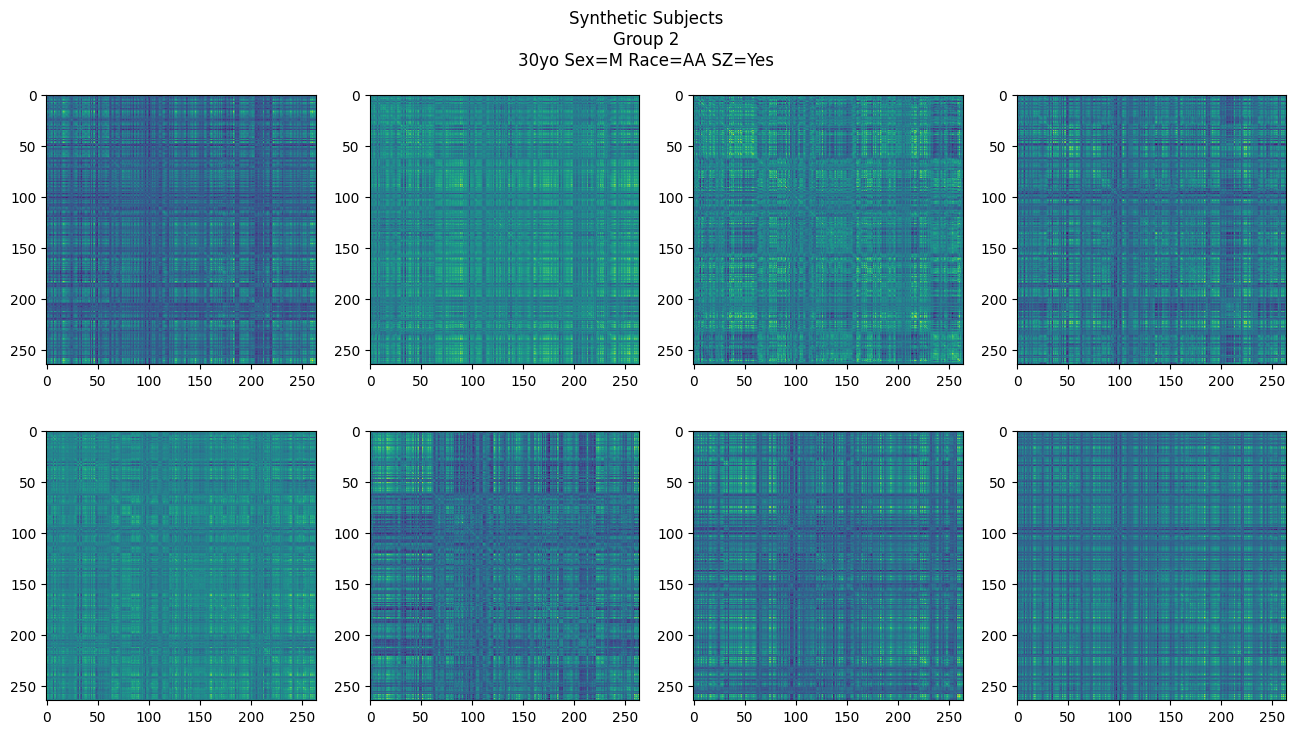

In [69]:
fig, ax = plt.subplots(2,4,figsize=(16,8))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(subj2[i*4+j]))
        
fig.suptitle('Synthetic Subjects\nGroup 2\n30yo Sex=M Race=AA SZ=Yes')
# fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/SyntheticGroup2.pdf')
fig.show()

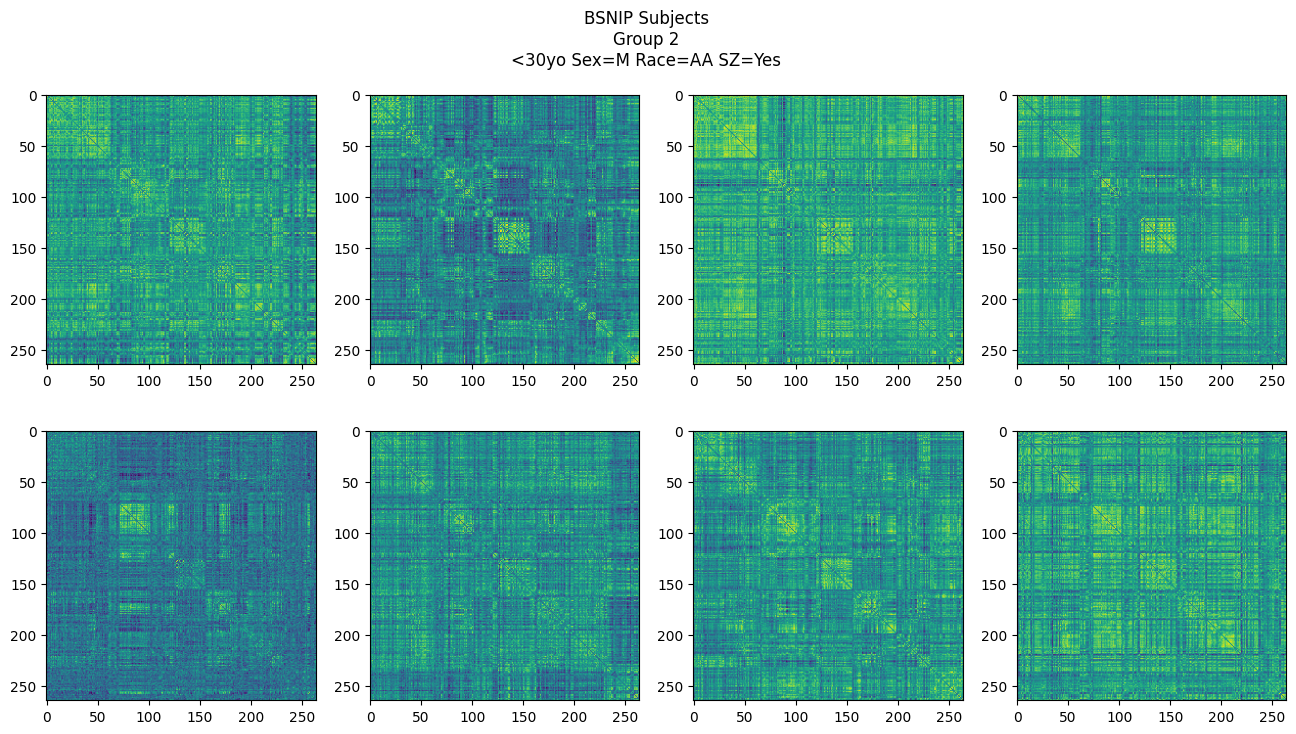

In [93]:
fig, ax = plt.subplots(2,4,figsize=(16,8))

# sel = (age < 30)*(sex == 0)*(race == 0)*(sz == 0)
sel = (age < 30)*(sex == 1)*(race == 1)*(sz == 1)
g2 = fc[sel]

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(vec2mat(g2[i*4+j])))
        
# fig.suptitle('BSNIP Subjects\nGroup 1\n<30yo Sex=F Race=CA SZ=No')
fig.suptitle('BSNIP Subjects\nGroup 2\n<30yo Sex=M Race=AA SZ=Yes')
fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/BSNIPGroup2.pdf')
fig.show()

In [185]:
efc = gen.fc().detach().cpu().numpy()
print(efc.shape)

wage = mage.coef_.squeeze()
bage = mage.intercept_

ahat = efc@wage+bage

wsex = msex.coef_.squeeze()
bsex = msex.intercept_

shat = efc@wsex+bsex
print(ahat)
print(age[1])
print(shat)
print(sex[1])

(34716,)
99.34299482797942
53
[-4.93360614]
1
